In [407]:
import numpy as np
import pandas as pd

import anndata as ad
import spatialdata as sd
import spatialdata_plot
from spatialdata import SpatialData
from spatialdata_io import xenium
from spatialdata import polygon_query

import scanpy as sc
import squidpy as sq

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib_venn import venn3
from matplotlib.colors import ListedColormap

import seaborn as sns

import os

import mygene

import copy

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde 
from scipy.signal import find_peaks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
varrone_df = pd.read_csv('/mnt/ndata/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_cell_types.csv')

In [3]:
adata_big = sc.read_h5ad("/mnt/ndata/virginia/project/breast_cancer_atlas_cellxgene_epithelial.h5ad")

In [4]:
adata_small = sc.read('/mnt/ndata/virginia/project/adata_new.h5ad')

In [641]:
xenium = sd.read_zarr("/mnt/ndata/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
feature = pd.read_csv("/mnt/ndata/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_phikon_icy-salad-378.csv")

In [7]:
adata_small.X = adata_small.raw.X # Per rendere grezzi i dati normalizzati
adata_small.X.data # Questo è per visualizzare se i dati sono normalizzati oppure grezzi

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [8]:
#1. filtro il adata_small e mantengo solo le cellule epiteliali
adata_small_epit = adata_small[
    (adata_small.obs['celltype_major'].isin(['Normal Epithelial', 'Cancer Epithelial']))].copy()

In [9]:
#2. modifico i nomi in adata_small_epit ovvero Cancer Epithelial in Malignant_epithelial e Normal Epithelial in Normal_epithelial 
adata_small_epit.obs["celltype_major"] = adata_small_epit.obs["celltype_major"].replace(
    {"Cancer Epithelial": "Malignant_epithelial", "Normal Epithelial": "Normal_epithelial"})

/tmp/ipykernel_148822/277219719.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_small_epit.obs["celltype_major"] = adata_small_epit.obs["celltype_major"].replace(


In [642]:
# Recupero gli Ensembl IDs da data.table.var['gene_ids']
xenium_gene_ids = xenium.table.var['gene_ids'].tolist()  # Lista degli ID dei geni in 'xenium'

# Recupero gli Ensembl IDs da adata_new.var_names
adata_gene_ids = adata_big.var['feature_id'].tolist()  # Lista degli ID dei geni in adata_big

# Confronto gli ID dei geni
only_in_xenium = set(xenium_gene_ids) - set(adata_gene_ids)
only_in_adata = set(adata_gene_ids) - set(xenium_gene_ids)

print(f"Genes only in xenium: {len(only_in_xenium)}")  
print(f"Genes only in adata_big: {len(only_in_adata)}")

# Filtro adata_big per mantenere solo i geni che sono in 'data'
adata_big_filtered = adata_big[:, adata_big.var['feature_id'].isin(xenium_gene_ids)]
print(f"After filtering, the shape of adata_big_filtered is: {adata_big_filtered.shape}")  

common_genes_filtered = set(xenium_gene_ids).intersection(set(adata_big_filtered.var['feature_id']))  
print(f"Number of common genes after filtering: {len(common_genes_filtered)}")  

Genes only in xenium: 0
Genes only in adata_big: 61608
After filtering, the shape of adata_big_filtered is: (1101803, 280)
Number of common genes after filtering: 280


/tmp/ipykernel_148822/1563870063.py:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  xenium_gene_ids = xenium.table.var['gene_ids'].tolist()  # Lista degli ID dei geni in 'xenium'


In [643]:
adata_big_filtered.layers["counts"] = adata_big_filtered.X.copy()
adata_big_filtered.var = adata_big_filtered.var[['feature_id'] + [col for col in adata_big_filtered.var.columns if col != 'feature_id']]
adata_big_filtered.var.set_index("feature_id", inplace=True)

/tmp/ipykernel_148822/2983062528.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_big_filtered.layers["counts"] = adata_big_filtered.X.copy()


In [644]:
#3. creo un terzo anndata unendo adata_small e adata_big e lo faccio in base ai nomi Normal_epithelial e Malignant_epithelial
adata_combined = ad.concat([adata_small_epit, adata_big_filtered], join="outer")

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/_core/merge.py:1410: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [645]:
adata_xenium = xenium.tables['table']

In [646]:
adata_xenium_cell_ids = set(adata_xenium.obs['cell_id'])

In [647]:
filtered_varrone_df = varrone_df[varrone_df['cell_id'].isin(adata_xenium_cell_ids)]

In [648]:
# Aggiungo la colonna 'level1' da varrone_df a adata_original.obs in base al 'cell_id'
adata_xenium.obs['level1'] = adata_xenium.obs['cell_id'].map(filtered_varrone_df.set_index('cell_id')['level1'])
adata_xenium.obs['level2'] = adata_xenium.obs['cell_id'].map(filtered_varrone_df.set_index('cell_id')['level2'])

adata_xenium.obs['level2'] = adata_xenium.obs['level2'].replace({
    'Malignant_epithelial': 'Malignant',
    'Normal_epithelial': 'Normal'})

In [649]:
# Filtro l'AnnData per includere solo le cellule con 'Epithelial' in 'level1'
epithelial_cells = adata_xenium[adata_xenium.obs['level1'] == 'Epithelial']

num_epithelial_cells = epithelial_cells.shape[0]
print(f"Number of epithelial cells: {num_epithelial_cells}")  

Number of epithelial cells: 350729


In [650]:
epithelial_cells.var_names = epithelial_cells.var['gene_ids']

In [651]:
sc.pp.normalize_total(epithelial_cells, inplace=True)
sc.pp.log1p(epithelial_cells) 

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [388]:
# DATASET: IDC TUMOR + IDC NORMAL 

# Filtro combinato per includere: 
# - IDC (ductal) con 'malignant' e 'normal'

adata_filtered_IDC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) 
].copy()

adata_filtered_IDC

AnnData object with n_obs × n_vars = 22196 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [570]:
# DATASET: IDC TUMOR + IDC NORMAL + ILC NORMAL

# Filtro combinato per includere:
# - IDC (ductal) con 'malignant' e 'normal'
# - ILC (lobular) solo con 'normal'

adata_filtered_IDC_normal_ILC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) |
    (
        (adata_combined.obs['disease'] == 'invasive lobular breast carcinoma') &
        (adata_combined.obs['celltype_major'] == 'Normal_epithelial')
    )
].copy()

adata_filtered_IDC_normal_ILC

AnnData object with n_obs × n_vars = 24184 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [389]:
# DATASET: IDC TUMOR + IDC NORMAL + ILC NORMAL + ILC TUMOR

# Filtro combinato per includere:
# - IDC (ductal) con 'malignant' e 'normal'
# - ILC (lobular) con 'malignant' e 'normal'

adata_filtered_IDC_ILC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) |
    (
        (adata_combined.obs['disease'] == 'invasive lobular breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    )
].copy()

adata_filtered_IDC_ILC

AnnData object with n_obs × n_vars = 26619 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [571]:
# Parametri modificabili

a = adata_filtered_IDC_normal_ILC
#a = adata_filtered_IDC
#a = adata_filtered_IDC_ILC

b = 'IDC_and_Normal_ILC'
#b = 'IDC'
#b = 'IDC_ILC'

group = "celltype_major"
variable = "logfoldchanges"
n_genes = 50

In [572]:
sc.pp.normalize_total(a, inplace=True)
sc.pp.log1p(a) 

In [573]:
# Filtra i geni in a in modo che contenga solo quelli che sono presenti in epithelial_cells.var_names ovvero 280
a_filtered = a[:, a.var_names.isin(epithelial_cells.var_names)].copy()
print(len(a_filtered.var_names))

280


In [574]:
sc.tl.rank_genes_groups(a_filtered, groupby=group, method="wilcoxon")

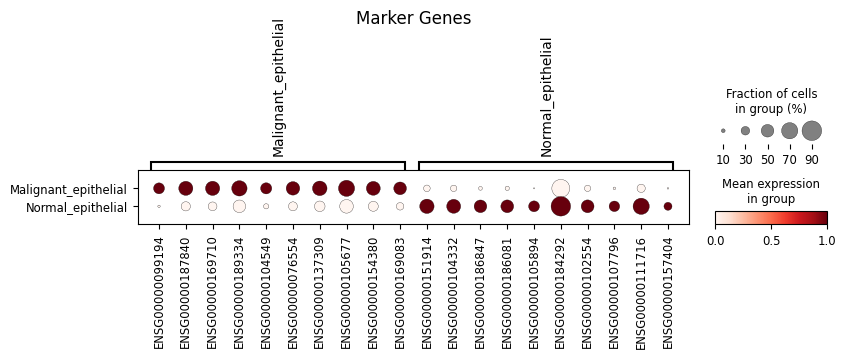

In [575]:
# DOTPLOT
dotplot = sc.pl.rank_genes_groups_dotplot(
    a_filtered,
    groupby=group,
    standard_scale="var",
    n_genes=10,                  
    title="Marker Genes",
    show=True)

#plt.savefig(f"Marker_Genes_DOTPLOT_{b}.png", dpi=300, bbox_inches="tight")
#plt.close()

In [576]:
#cancer_genes = sc.get.rank_genes_groups_df(a_filtered, group="Malignant_epithelial")
#output_path = f'results/cancer_genes_Malignant_epithelial_{b}.csv'
#cancer_genes.to_csv(output_path, index=False)

cancer_genes = pd.read_csv('results/cancer_genes_Malignant_epithelial_IDC_and_Normal_ILC.csv') # IDC_and_Normal_ILC
#cancer_genes = pd.read_csv('results/cancer_genes_Malignant_epithelial_IDC.csv') # IDC
#cancer_genes = pd.read_csv('results/cancer_genes_Malignant_epithelial_IDC_ILC.csv') # IDC_and_ILC

In [577]:
cancer_genes.sort_values('logfoldchanges')

,names,scores,logfoldchanges,pvals,pvals_adj
219,ENSG00000182916,-4.348114,-6.773314,1.373133e-05,3.527313e-05
275,ENSG00000105894,-41.003284,-6.489508,0.000000e+00,0.000000e+00
255,ENSG00000133392,-16.992723,-5.751114,9.297167e-65,5.916379e-64
250,ENSG00000137285,-13.192143,-5.509456,9.737616e-40,5.049134e-39
208,ENSG00000176692,-2.246025,-5.501187,2.470242e-02,5.048670e-02
...,...,...,...,...,...
110,ENSG00000177575,0.252866,3.942485,8.003717e-01,9.875694e-01
30,ENSG00000166803,9.565592,4.116506,1.115616e-21,4.462465e-21
117,ENSG00000262406,0.205918,4.617603,8.368551e-01,9.971039e-01
25,ENSG00000148773,11.163978,6.445093,6.119107e-29,2.677109e-28


In [578]:
cancer_genes_log = cancer_genes[(cancer_genes[variable] > 0.58) & (cancer_genes['pvals'] <= 0.01)]
normal_genes_log = cancer_genes[(cancer_genes[variable] < -0.58) & (cancer_genes['pvals'] <= 0.01)]

In [579]:
# Assegna il risultato con chiave dinamica
df_epit_selected_cancer = cancer_genes_log.sort_values(by=variable, ascending=False).head(n_genes)['names']
df_epit_selected_normal= normal_genes_log.sort_values(by=variable, ascending=True).head(n_genes)['names']

In [652]:
# Score su epithelial_cells
sc.tl.score_genes(epithelial_cells, df_epit_selected_cancer, ctrl_as_ref=True, score_name='malignant_epithelial_score')
sc.tl.score_genes(epithelial_cells, df_epit_selected_normal, ctrl_as_ref=True, score_name='normal_epithelial_score')

In [582]:
df_epit_selected_cancer_IDC_and_Normal_ILC = df_epit_selected_cancer
#df_epit_selected_cancer_IDC = df_epit_selected_cancer
#df_epit_selected_cancer_IDC_ILC = df_epit_selected_cancer

df_epit_selected_normal_IDC_and_Normal_ILC = df_epit_selected_normal
#df_epit_selected_normal_IDC = df_epit_selected_normal
#df_epit_selected_normal_IDC_ILC = df_epit_selected_normal

In [547]:
sig_idc = df_epit_selected_cancer_IDC
sig_idc_ilcTN = df_epit_selected_cancer_IDC_ILC
sig_idc_ilcN = df_epit_selected_cancer_IDC_and_Normal_ILC

In [548]:
# Supponiamo che le signature siano liste di geni
signature_idc = set(sig_idc)  # idc (tumor+normal)
signature_idc_ilcN = set(sig_idc_ilcN)  # idc (tumor+normal) + ilc(normal)
signature_idc_ilcTN = set(sig_idc_ilcTN)  # idc (tumor+normal) + ilc(tumor+normal)

# Intersezione tra tutte e tre
intersection_all = signature_idc & signature_idc_ilcN & signature_idc_ilcTN

# Geni unici per ogni signature
unique_idc = signature_idc - (signature_idc_ilcN | signature_idc_ilcTN)
unique_idc_ilcN = signature_idc_ilcN - (signature_idc | signature_idc_ilcTN)
unique_idc_ilcTN = signature_idc_ilcTN - (signature_idc | signature_idc_ilcN)

# Geni condivisi solo tra alcune
shared_idc_ilcN = signature_idc & signature_idc_ilcN
shared_idc_ilcTN = signature_idc & signature_idc_ilcTN
shared_ilcN_ilcTN = signature_idc_ilcN & signature_idc_ilcTN

# Condivisi solo tra IDC e ILC(N), esclusi da ILC(T)
shared_only_idc_ilcN = (signature_idc & signature_idc_ilcN) - signature_idc_ilcTN
# Condivisi solo tra IDC e ILC(TN), esclusi da ILC(N)
shared_only_idc_ilcTN = (signature_idc & signature_idc_ilcTN) - signature_idc_ilcN
# Condivisi solo tra ILC(N) e ILC(TN), esclusi da IDC
shared_only_ilcN_ilcTN = (signature_idc_ilcN & signature_idc_ilcTN) - signature_idc

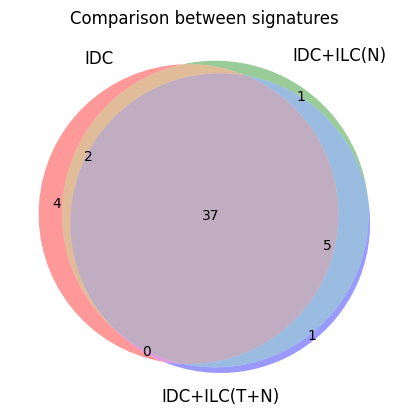

In [549]:
venn3([signature_idc, signature_idc_ilcN, signature_idc_ilcTN], 
      set_labels=('IDC', 'IDC+ILC(N)', 'IDC+ILC(T+N)'))
plt.title("Comparison between signatures")
plt.show()

In [655]:
gene_sets = {
    'Only_IDC': unique_idc,
    'Only_IDC_ILC_N': unique_idc_ilcN,
    'Only_IDC_ILC_TN': unique_idc_ilcTN,
    'Shared_all': intersection_all,
    'Shared_only_IDC_ILC_N': shared_only_idc_ilcN,
    'Shared_only_IDC_ILC_TN': shared_only_idc_ilcTN,
    'Shared_only_ILC_N_ILC_TN': shared_only_ilcN_ilcTN
}

In [557]:
mg = mygene.MyGeneInfo()

# Prendi tutti gli ensembl IDs da tutti i set
all_ensembl_ids = set().union(*gene_sets.values())

# Fai il mapping
result = mg.querymany(list(all_ensembl_ids), scopes='ensembl.gene', fields='symbol', species='human')

# Crea dizionario di conversione {ensembl_id: gene_symbol}
ensembl_to_symbol = {item['query']: item.get('symbol', item['query']) for item in result}

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [558]:
gene_sets_symbol = {
    key: {ensembl_to_symbol.get(gene_id, gene_id) for gene_id in gene_list}
    for key, gene_list in gene_sets.items()}

In [561]:
# Converti il dizionario in una lista di righe
rows = []
for category, genes in gene_sets_symbol.items():
    for gene in sorted(genes):
        rows.append({'Group': category, 'Gene Symbol': gene})

# Crea un DataFrame
df = pd.DataFrame(rows)

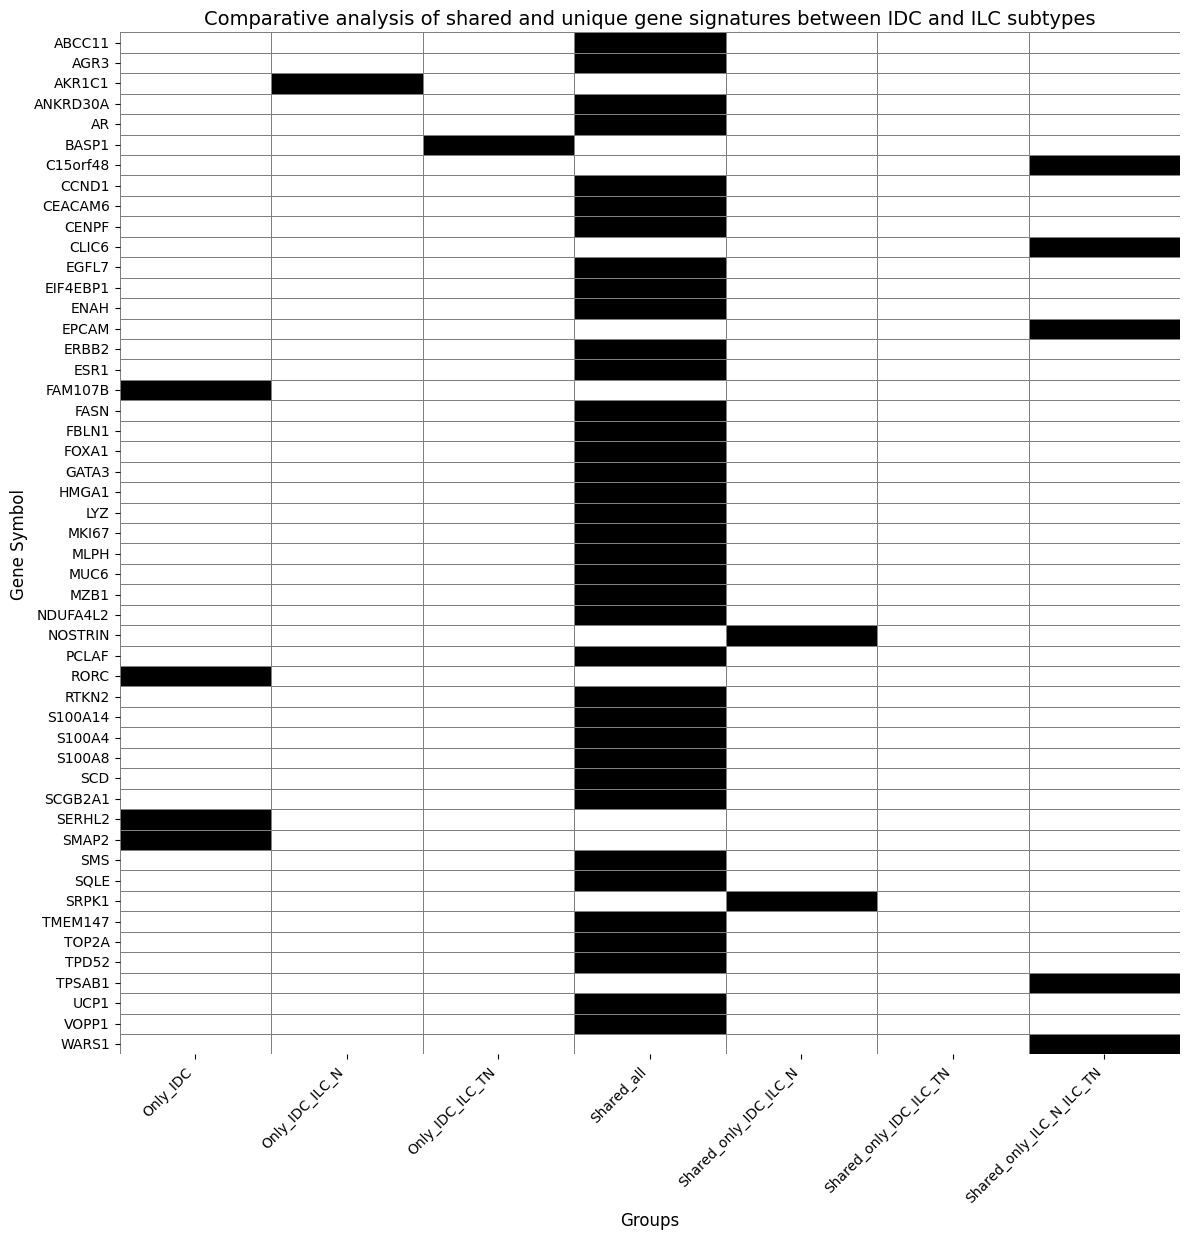

In [568]:
# Crea la matrice binaria: righe = geni, colonne = gruppi
all_genes = sorted(set().union(*gene_sets_symbol.values()))
all_groups = gene_sets_symbol.keys()

data = {
    group: [1 if gene in gene_sets_symbol[group] else 0 for gene in all_genes]
    for group in all_groups}

df_binary = pd.DataFrame(data, index=all_genes)

# Crea una colormap: 0 = bianco, 1 = nero
bw_cmap = ListedColormap(["white", "black"])

plt.figure(figsize=(12, len(all_genes) * 0.25))
sns.heatmap(
    df_binary,
    cmap=bw_cmap,
    cbar=False,
    linewidths=0.5,
    linecolor='grey')  # opzionale per separare le celle

plt.title("Comparative analysis of shared and unique gene signatures between IDC and ILC subtypes", fontsize=14)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Gene Symbol", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

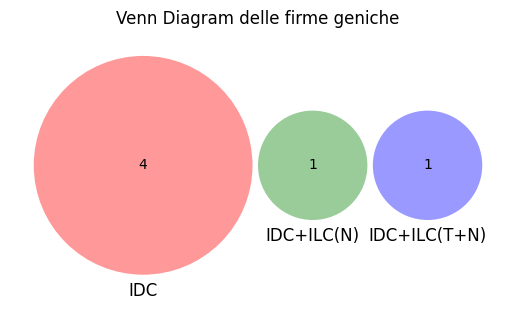

In [567]:
venn3(
    [gene_sets_symbol['Only_IDC'], 
     gene_sets_symbol['Only_IDC_ILC_N'], 
     gene_sets_symbol['Only_IDC_ILC_TN']],
    set_labels=('IDC', 'IDC+ILC(N)', 'IDC+ILC(T+N)')
)
plt.title("Venn Diagram delle firme geniche")
plt.show()

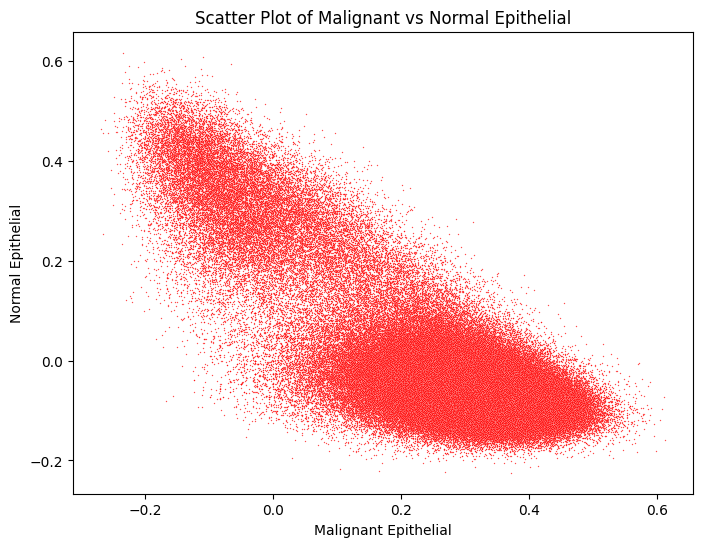

In [583]:
# SCATTERPLOT
x = epithelial_cells.obs['malignant_epithelial_score']
y = epithelial_cells.obs['normal_epithelial_score']

plt.figure(figsize=(8, 6))

sns.scatterplot(x=x, y=y, color='red', alpha=0.7, s=1)

plt.xlabel('Malignant Epithelial')
plt.ylabel('Normal Epithelial')
plt.title('Scatter Plot of Malignant vs Normal Epithelial')
plt.show()

#plt.savefig(f"SCATTER_malignant_vs_normal_{b}.png", dpi=300, bbox_inches="tight")
#plt.close()

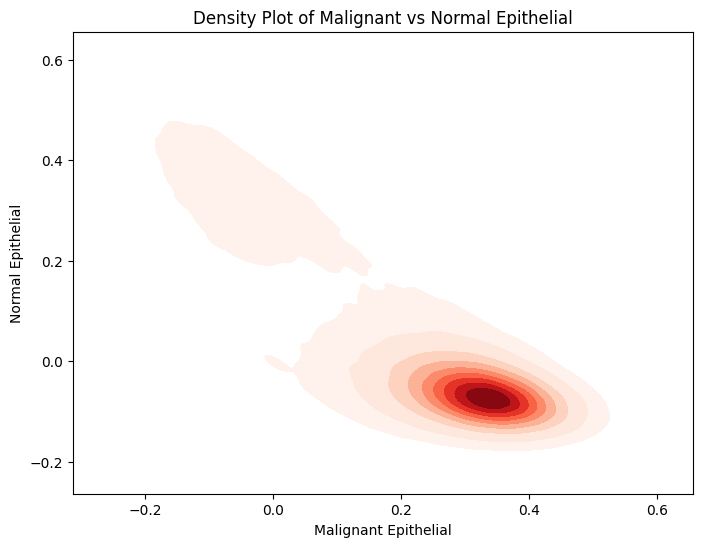

In [584]:
# DENSITY PLOT
x = epithelial_cells.obs['malignant_epithelial_score']
y = epithelial_cells.obs['normal_epithelial_score']

plt.figure(figsize=(8, 6))

sns.kdeplot(x=x, y=y, cmap="Reds", fill=True, thresh=0.05)

plt.xlabel('Malignant Epithelial')
plt.ylabel('Normal Epithelial')
plt.title('Density Plot of Malignant vs Normal Epithelial')
plt.show()

#plt.savefig(f"DENSITY_malignant_vs_normal_{b}.png", dpi=300, bbox_inches="tight")
#plt.close() 

Cell type counts:
 cell_type_prediction
Malignant    320384
Normal        25463
Unknown        4882
Name: count, dtype: int64


/tmp/ipykernel_148822/1624317675.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


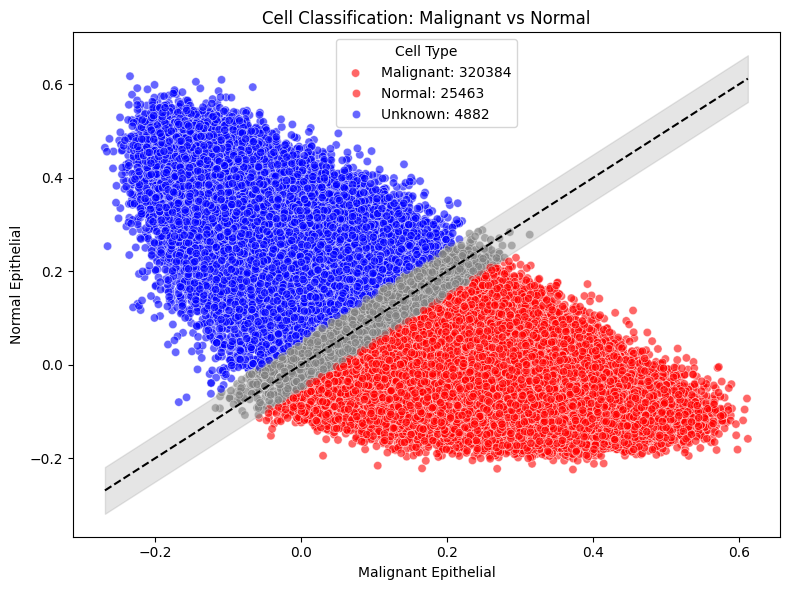

/tmp/ipykernel_148822/1624317675.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cell_counts.index, y=cell_counts.values, palette=['red', 'blue', 'gray'])


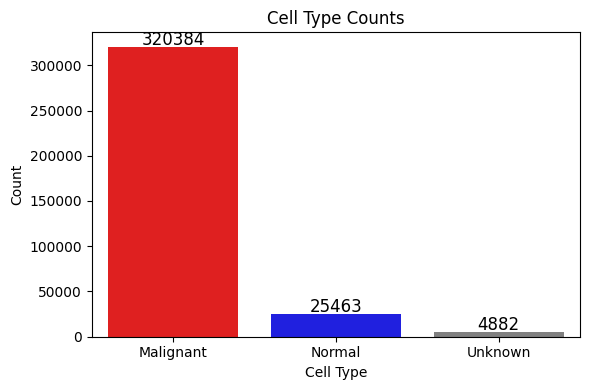

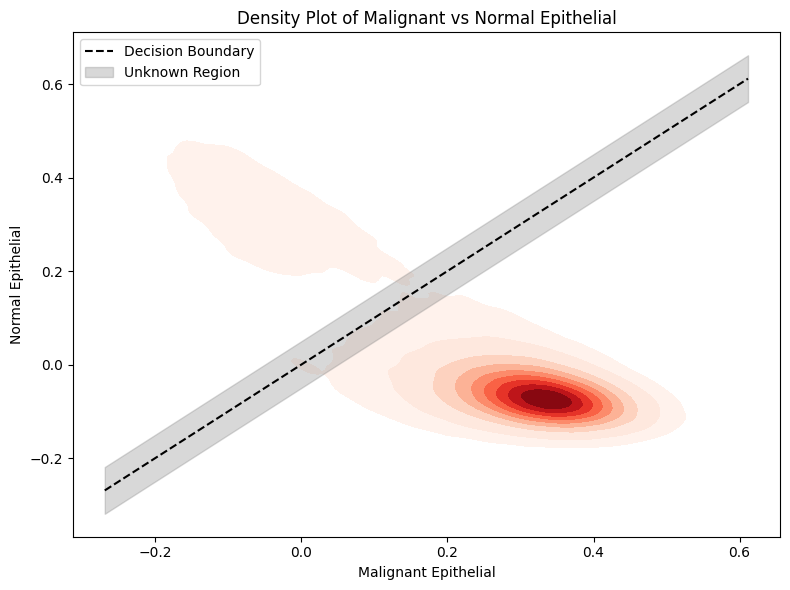

In [659]:
x = epithelial_cells.obs['malignant_epithelial_score']
y = epithelial_cells.obs['normal_epithelial_score']

# Parametro: larghezza della fascia "unknown"
boundary_width = 0.05

# Calcolo della differenza
diff = y - x

# Funzione di classificazione
def classify(diff_value, threshold):
    if diff_value > threshold:
        return 'Normal'
    elif diff_value < -threshold:
        return 'Malignant'
    else:
        return 'Unknown'

# Applica la classificazione
epithelial_cells.obs['cell_type_prediction'] = diff.apply(lambda d: classify(d, threshold=boundary_width))

# Conta le cellule per categoria
cell_counts = epithelial_cells.obs['cell_type_prediction'].value_counts()
print("Cell type counts:\n", cell_counts)

# --- SCATTERPLOT CON DIAGONALE E FASCIA "UNKNOWN" ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=x,
    y=y,
    hue=epithelial_cells.obs['cell_type_prediction'],
    hue_order=['Malignant', 'Normal', 'Unknown'],  # ordine esplicito
    palette={'Malignant': 'red', 'Normal': 'blue', 'Unknown': 'gray'},
    alpha=0.6
)

plt.plot([x.min(), x.max()], [x.min(), x.max()], color='black', linestyle='--', label='Decision Boundary')
x_vals = np.linspace(x.min(), x.max(), 500)
plt.fill_between(x_vals, x_vals - boundary_width, x_vals + boundary_width, 
                 color='gray', alpha=0.2, label='Unknown Region')
plt.xlabel('Malignant Epithelial')
plt.ylabel('Normal Epithelial')
plt.title('Cell Classification: Malignant vs Normal')
plt.legend(title="Cell Type", labels=[
    f"Malignant: {cell_counts.get('Malignant', 0)}", 
    f"Normal: {cell_counts.get('Normal', 0)}", 
    f"Unknown: {cell_counts.get('Unknown', 0)}"
])
plt.tight_layout()
plt.show()

# --- BARPLOT CONTEGGIO CELLULE ---
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=cell_counts.index, y=cell_counts.values, palette=['red', 'blue', 'gray'])
plt.title('Cell Type Counts')
plt.xlabel('Cell Type')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

# --- DENSITY PLOT PER DATASET MOLTO GRANDI ---
plt.figure(figsize=(8, 6))
sns.kdeplot(x=x, y=y, cmap="Reds", fill=True, thresh=0.05)
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='black', linestyle='--', label='Decision Boundary')
plt.fill_between(x_vals, x_vals - boundary_width, x_vals + boundary_width, 
                 color='gray', alpha=0.3, label='Unknown Region')
plt.xlabel('Malignant Epithelial')
plt.ylabel('Normal Epithelial')
plt.title('Density Plot of Malignant vs Normal Epithelial')
plt.legend()
plt.tight_layout()
plt.show()

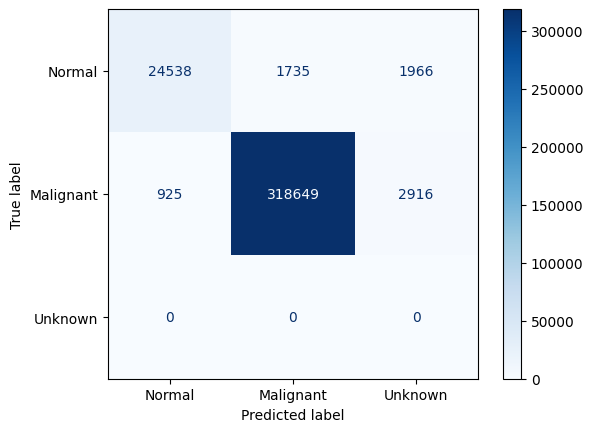

In [291]:
# Creo la confusion matrix
y_true = epithelial_cells.obs['level2']
y_pred = epithelial_cells.obs['cell_type_prediction']

# Calcolo la confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["Normal", "Malignant", "Unknown"])

# Mostro la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Malignant", "Unknown"])
disp.plot(cmap='Blues', values_format='d')

In [41]:
# Calcolo e stampo il report di classificazione
report = classification_report(
    epithelial_cells.obs['level2'],
    epithelial_cells.obs['cell_type_prediction'],
    labels=["Normal", "Malignant"],  # Escludiamo Unknown perché nei true label non c'è
    target_names=["Normal", "Malignant"])

print(report)

              precision    recall  f1-score   support

      Normal       0.96      0.87      0.91     28239
   Malignant       0.99      0.99      0.99    322490

   micro avg       0.99      0.98      0.99    350729
   macro avg       0.98      0.93      0.95    350729
weighted avg       0.99      0.98      0.99    350729



In [657]:
# Crea una copia profonda di xenium
xenium_new_classification = copy.deepcopy(xenium)

# Estrai i metadati da epithelial_cells
metadata = epithelial_cells.obs[['level1', 'level2', 'cell_type_prediction']]

# Identifica gli indici mancanti in xenium_epithelial.table.obs
missing_indices = set(xenium_new_classification.table.obs.index) - set(epithelial_cells.obs.index)

# Crea i metadati mancanti
missing_metadata = pd.DataFrame(
    index=list(missing_indices),
    data={"level1": "Other", "level2": "Other", "cell_type_prediction": "Other"}
)

# Estrai i metadati esistenti per le cellule epiteliali
existing_metadata = metadata.loc[metadata.index.intersection(xenium_new_classification.table.obs.index)]

# Combina i metadati
full_metadata = pd.concat([existing_metadata, missing_metadata]).reindex(xenium_new_classification.table.obs.index)

# Assegna i nuovi metadati alla copia
xenium_new_classification.table.obs[['level1', 'level2', 'cell_type_prediction']] = full_metadata[['level1', 'level2', 'cell_type_prediction']]

# Verifica
print(xenium_new_classification.table.obs.head())

/tmp/ipykernel_148822/1502480340.py:8: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  missing_indices = set(xenium_new_classification.table.obs.index) - set(epithelial_cells.obs.index)
/tmp/ipykernel_148822/1502480340.py:17: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  existing_metadata = metadata.loc[metadata.index.intersection(xenium_new_classification.table.obs.index)]


   cell_id  transcript_counts  control_probe_counts  control_codeword_counts  \
0        1                 73                     0                        0   
1        2                 43                     0                        0   
2        3                 56                     0                        0   
3        4                 61                     0                        0   
4        5                130                     0                        0   

   total_counts   cell_area  nucleus_area        region  \
0            73  151.408906     26.597031  cell_circles   
1            43   70.127656      9.257031  cell_circles   
2            56   56.355000     10.792344  cell_circles   
3            61  132.036875     15.262813  cell_circles   
4           130  138.765156     19.733281  cell_circles   

                            sample level1 level2 cell_type_prediction  
0  Xenium_V1_FFPE_Human_Breast_IDC  Other  Other                Other  
1  Xenium_V1_FFPE_Hu

/tmp/ipykernel_148822/1502480340.py:20: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  full_metadata = pd.concat([existing_metadata, missing_metadata]).reindex(xenium_new_classification.table.obs.index)
/tmp/ipykernel_148822/1502480340.py:23: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  xenium_new_classification.table.obs[['level1', 'level2', 'cell_type_prediction']] = full_metadata[['level1', 'level2', 'cell_type_prediction']]
/tmp/ipykernel_148822/1502480340.py:26: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print(xenium_new_classification.table.obs.head())


In [658]:
xenium_new_classification.tables['table'].uns['spatialdata_attrs']['region'] = 'nucleus_boundaries'
xenium_new_classification.tables['table'].obs['region']='nucleus_boundaries'

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata_plot/pl/basic.py:937: UserWarning: Converting copy of 'cell_type_prediction' column to categorical dtype for categorical plotting. Consider converting before plotting.
  _render_shapes(
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata_plot/pl/utils.py:771: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a futur

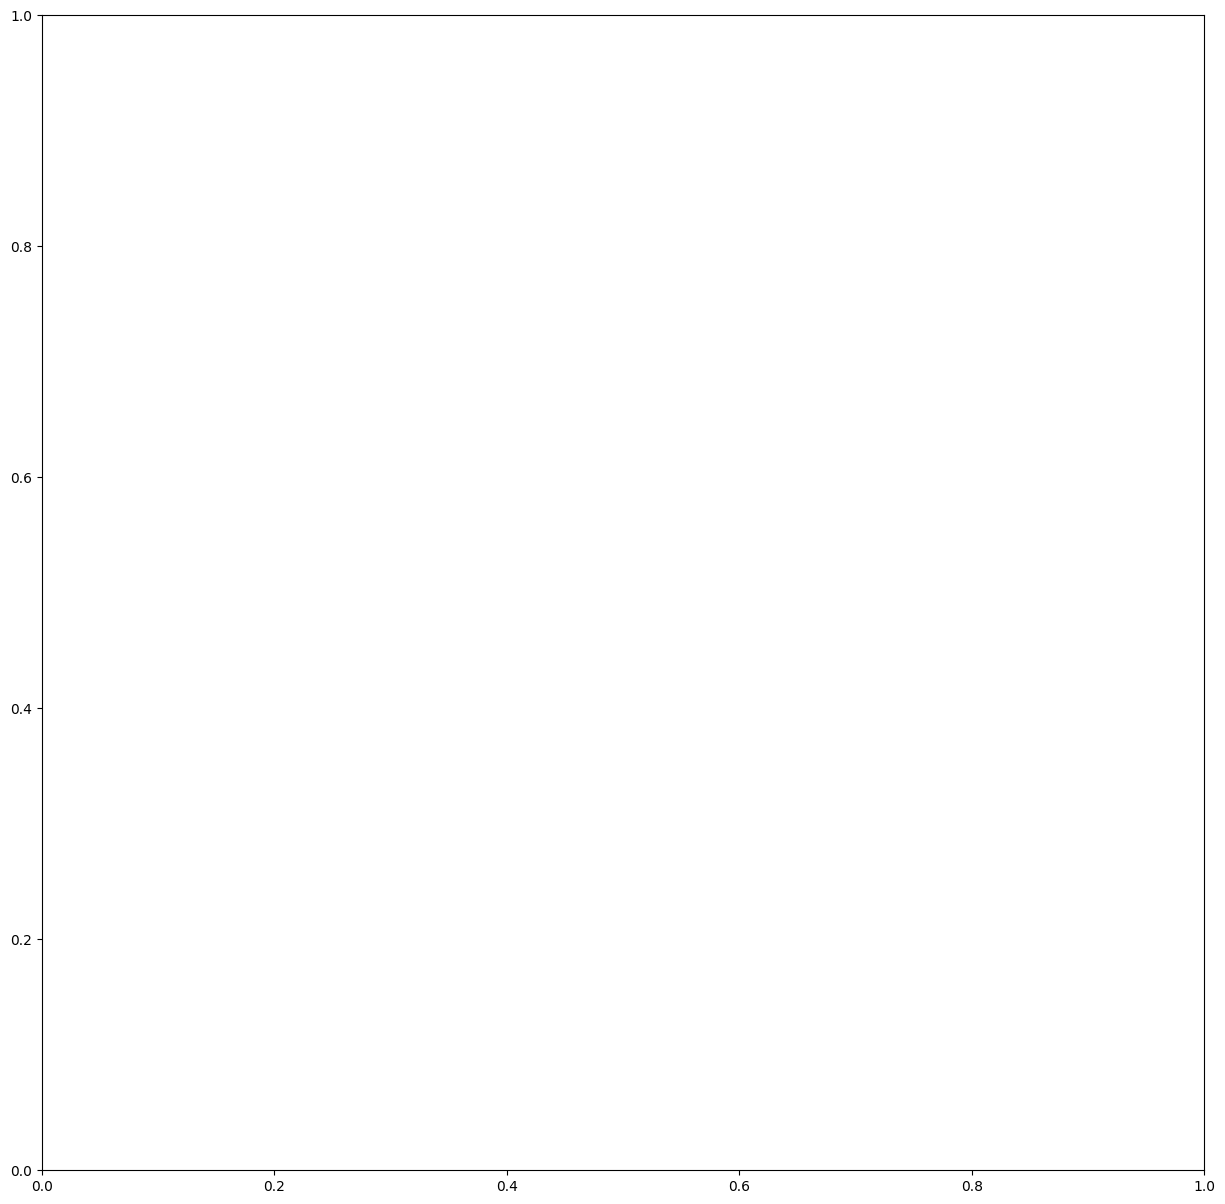

In [262]:
# CLASSIFICAZIONE di RIFERIMENTO
fig, ax = plt.subplots(figsize=(15, 15))
xenium_new_classification.pl.render_shapes(element='nucleus_boundaries', color='cell_type_prediction', method='matplotlib', ax=ax).pl.show()
plt.savefig(f"NUCLEUS_BOUNDARIES_cell_type_prediction_{b}.png", dpi=300, bbox_inches="tight")
plt.close()

In [288]:
# Add 'Unknown' category to 'level2'
xenium_new_classification.table.obs['level2'] = xenium_new_classification.table.obs['level2'].cat.add_categories('Unknown')

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata_plot/pl/utils.py:771: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


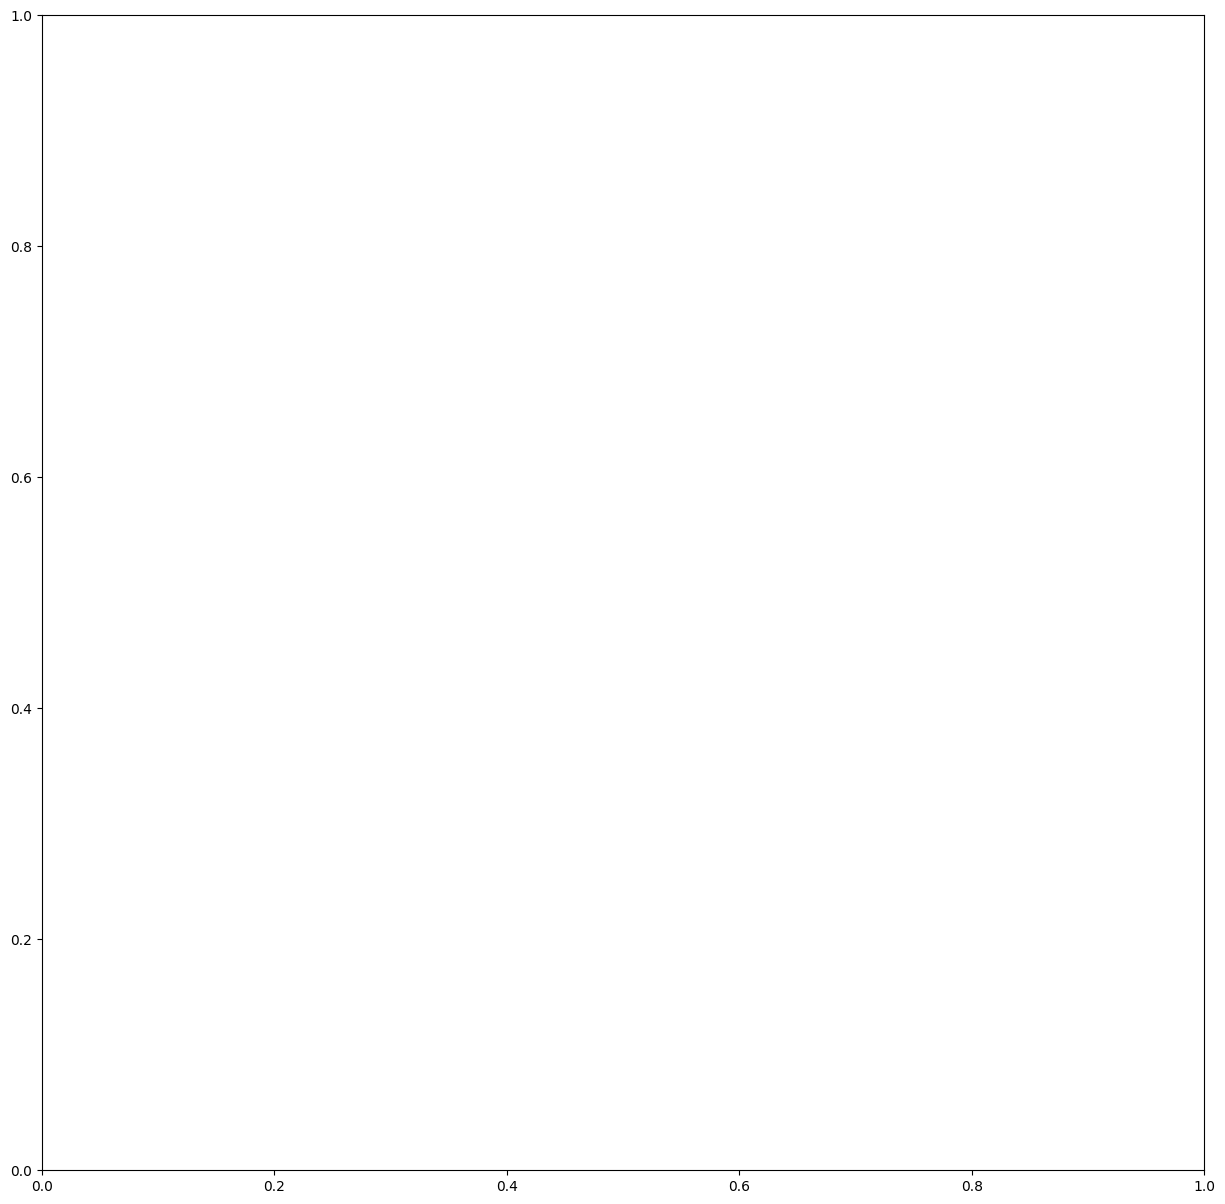

In [289]:
# CLASSIFICAZIONE INIZIALE
fig, ax = plt.subplots(figsize=(15, 15))
xenium_new_classification.pl.render_shapes(element='nucleus_boundaries', color='level2', method='matplotlib', ax=ax).pl.show()
plt.savefig(f"NUCLEUS_BOUNDARIES_level2_{b}.png", dpi=300, bbox_inches="tight")
plt.close()

/tmp/ipykernel_148822/1788569004.py:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  obs = xenium_new_classification.table.obs
/tmp/ipykernel_148822/1788569004.py:5: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  filtered_table = xenium_new_classification.table[mismatched_indices]
/tmp/ipykernel_148822/1788569004.py:11: DeprecationWarning: `table` is being deprecated as an argument to `SpatialData.__init__.__init__` in spatialdata version 0.1.0, switch to `tables` instead.
  mismatched_cells = SpatialData(
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarn

Number of mismatched cells: 7541


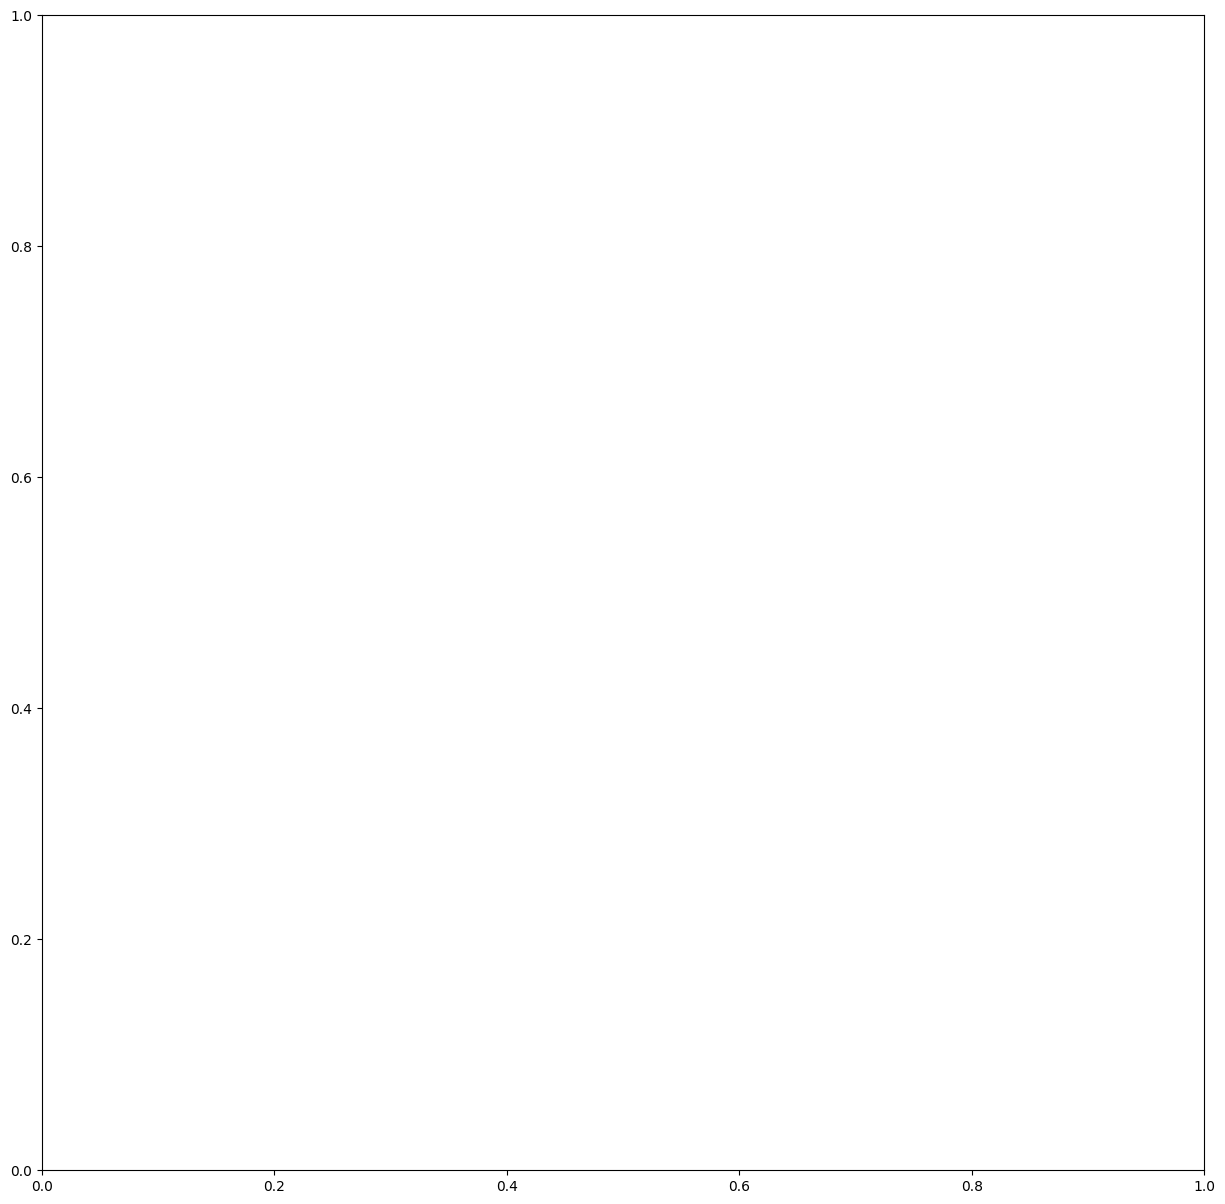

In [299]:
# DIFFERENZE nelle due CLASSIFICAZIONI
obs = xenium_new_classification.table.obs

mismatched_indices = obs.index[obs['cell_type_prediction'] != obs['level2']]
filtered_table = xenium_new_classification.table[mismatched_indices]

num_mismatched_cells = len(mismatched_indices)
print(f"Number of mismatched cells: {num_mismatched_cells}")

# Creo un nuovo oggetto SpatialData con le sole celle discordanti
mismatched_cells = SpatialData(
    table=filtered_table,
    shapes=xenium_new_classification.shapes)

fig, ax = plt.subplots(figsize=(15, 15))

mismatched_cells.pl.render_shapes(
    element='nucleus_boundaries', 
    color='cell_type_prediction', 
    method='matplotlib',
    ax=ax).pl.show()

plt.savefig(f"MISMATCHED_CELL_TYPE_PREDICTION_{b}.png", dpi=300, bbox_inches="tight")
plt.close()  

/tmp/ipykernel_148822/1487973094.py:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  cell_counts = mismatched_cells.table.obs['cell_type_prediction'].value_counts()
/tmp/ipykernel_148822/1487973094.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cell_counts.index, y=cell_counts.values, palette="viridis")


Conteggio cellule discordanti per tipo:
cell_type_prediction
Unknown      4881
Malignant    1735
Normal        925
Name: count, dtype: int64


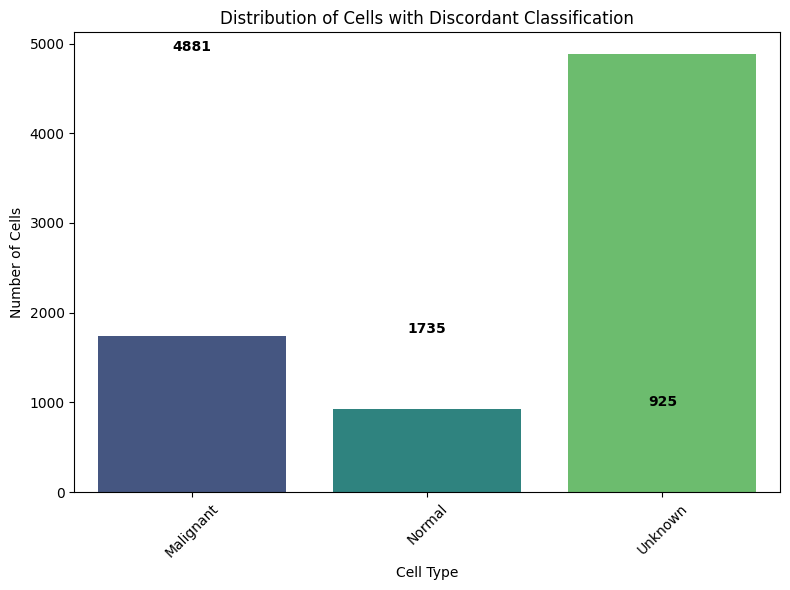

In [301]:
# Conta le cellule per tipo nel dataset "mismatched_cells"
cell_counts = mismatched_cells.table.obs['cell_type_prediction'].value_counts()

# Stampa i numeri precisi
print("Conteggio cellule discordanti per tipo:")
print(cell_counts)

# BARPLOT
plt.figure(figsize=(8,6))
ax = sns.barplot(x=cell_counts.index, y=cell_counts.values, palette="viridis")

# Aggiungi etichette numeriche sopra le barre
for i, count in enumerate(cell_counts.values):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontweight='bold')

plt.title("Distribution of Cells with Discordant Classification")  
plt.xlabel("Cell Type")  
plt.ylabel("Number of Cells")  
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.savefig(f"BARPLOT_discordant_cells_distribution_prediction_{b}.png", dpi=300, bbox_inches="tight")
plt.close()

In [277]:
# Trovo le cellule comuni tra adata_filtered e feature (usando gli indici del DataFrame feature)
common_cells = epithelial_cells.obs["cell_id"].isin(feature.index)

# Filtro adata_filtered per tenere solo le cellule con feature
adata_feature = epithelial_cells[common_cells].copy()

# Filtro le feature per tenere solo quelle con cell_id presenti in adata_feature
feature_matched = feature.loc[adata_feature.obs["cell_id"]]

# Controllo che l'ordine sia allineato (importantissimo!)
assert all(feature_matched.index == adata_feature.obs["cell_id"])

# Rimuovo la colonna cell_id se è presente
if "cell_id" in feature_matched.columns:
    feature_matched = feature_matched.drop(columns="cell_id")

# Inserisco le feature in obsm
adata_feature.obsm["phikon"] = feature_matched.to_numpy()

# (Facoltativo) salvo i nomi delle feature
adata_feature.uns["phikon_feature_names"] = feature_matched.columns.tolist()

# Salvo le feature in data
xenium_new_classification.tables["table"] = adata_feature

print(f"Features successfully added to `obsm['phikon']`! {adata_feature.n_obs} total cells after filtering.")

Features successfully added to `obsm['phikon']`! 350718 total cells after filtering.


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [278]:
# Conta le occorrenze di ciascun tipo cellulare nel dataset
cell_type_counts = adata_feature.obs['cell_type_prediction'].value_counts()

# Calcola il numero totale di cellule
total_cells = cell_type_counts.sum()

# Calcola le percentuali dinamicamente
malignant_pct_total = (cell_type_counts.get('Malignant', 0) / total_cells) * 100
normal_pct_total = (cell_type_counts.get('Normal', 0) / total_cells) * 100
unknown_pct_total = (cell_type_counts.get('Unknown', 0) / total_cells) * 100

In [279]:
sc.pp.neighbors(adata_feature, use_rep='phikon')

In [280]:
sc.tl.umap(adata_feature)

In [311]:
# Scegli il numero di componenti (cluster)
#n_comp = 2  # <-- modifica questo valore per cambiare il numero di cluster
#n_comp = 3
#n_comp = 4
#n_comp = 10
n_comp = 15

gmm_clusters_15
7     50068
2     38357
6     28631
9     27489
11    26548
1     24484
14    23928
10    21186
8     20660
4     19071
12    17546
3     14829
0     13327
13    12736
5     11858
Name: count, dtype: int64


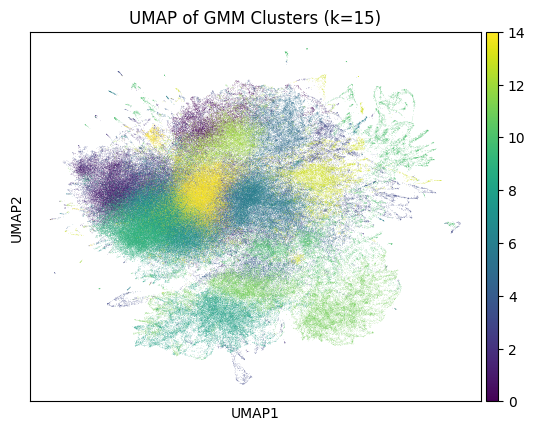

In [312]:
# Nome dinamico per la colonna
cluster_col = f'gmm_clusters_{n_comp}'

# Applica GMM
gmm = GaussianMixture(n_components=n_comp, random_state=42)
adata_feature.obs[cluster_col] = gmm.fit_predict(adata_feature.obsm['phikon'])

# Conta le cellule per cluster
print(adata_feature.obs[cluster_col].value_counts())

# (Opzionale) Calcola le probabilità per ogni cellula
probs = gmm.predict_proba(adata_feature.obsm['phikon'])

# UMAP colorata per cluster
sc.pl.umap(adata_feature, color=cluster_col, title=f'UMAP of GMM Clusters (k={n_comp})')

# Crea DataFrame con ID cellula e cluster assegnato
df = pd.DataFrame({
    'cell_id': adata_feature.obs['cell_id'].values,
    cluster_col: adata_feature.obs[cluster_col].values
})

# Salva il file CSV
df.to_csv(f'{cluster_col}.csv', index=False)

/tmp/ipykernel_148822/3012732272.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts = adata_feature.obs.groupby([cluster_col, "cell_type_prediction"]).size().unstack(fill_value=0)


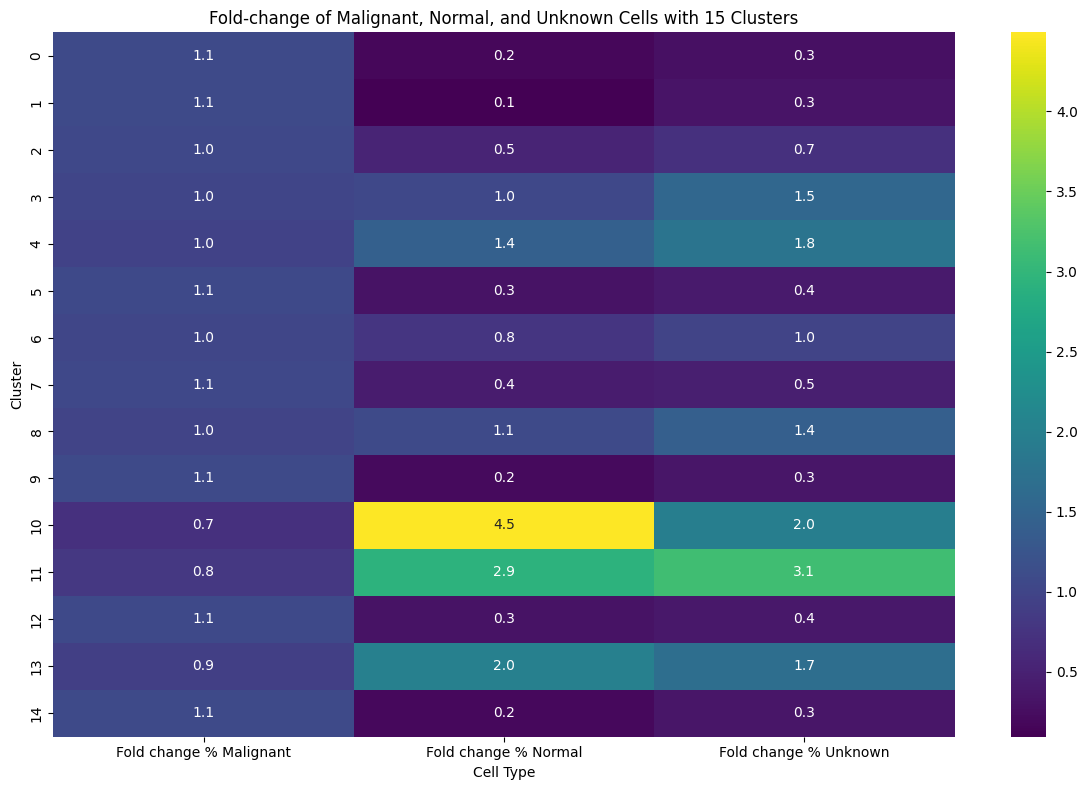

In [313]:
# Tabella a doppia entrata tra cluster e predizione del tipo cellulare
crosstab = pd.crosstab(adata_feature.obs[cluster_col], adata_feature.obs['cell_type_prediction'])

# Tabella con conteggio totale e percentuali
cluster_counts = adata_feature.obs.groupby([cluster_col, "cell_type_prediction"]).size().unstack(fill_value=0)
cluster_counts["Total"] = cluster_counts.sum(axis=1)
cluster_counts["Malignant %"] = cluster_counts["Malignant"] / cluster_counts["Total"] * 100
cluster_counts["Normal %"] = cluster_counts["Normal"] / cluster_counts["Total"] * 100
cluster_counts["Unknown %"] = cluster_counts["Unknown"] / cluster_counts["Total"] * 100

# Calcolo del fold-change rispetto alle percentuali complessive nell'intero dataset
# (valori hardcoded da te forniti, puoi calcolarli dinamicamente se preferisci)
cluster_counts["Fold change % Malignant"] = cluster_counts["Malignant %"] / malignant_pct_total
cluster_counts["Fold change % Normal"] = cluster_counts["Normal %"] / normal_pct_total
cluster_counts["Fold change % Unknown"] = cluster_counts["Unknown %"] / unknown_pct_total

# Visualizzazione heatmap dinamica
plt.figure(figsize=(12, 8))
sns.heatmap(
    cluster_counts[["Fold change % Malignant", "Fold change % Normal", "Fold change % Unknown"]],
    cmap="viridis", annot=True, fmt=".1f")

# Titolo dinamico
plt.title(f"Fold-change of Malignant, Normal, and Unknown Cells with {n_comp} Clusters")
plt.xlabel("Cell Type")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [ ]:
# Parametri
leiden_resolution = 0.6
min_cells = 1000
cluster_col = f'leiden_{str(leiden_resolution).replace(".", "")}'
cell_type_col = 'cell_type_prediction'

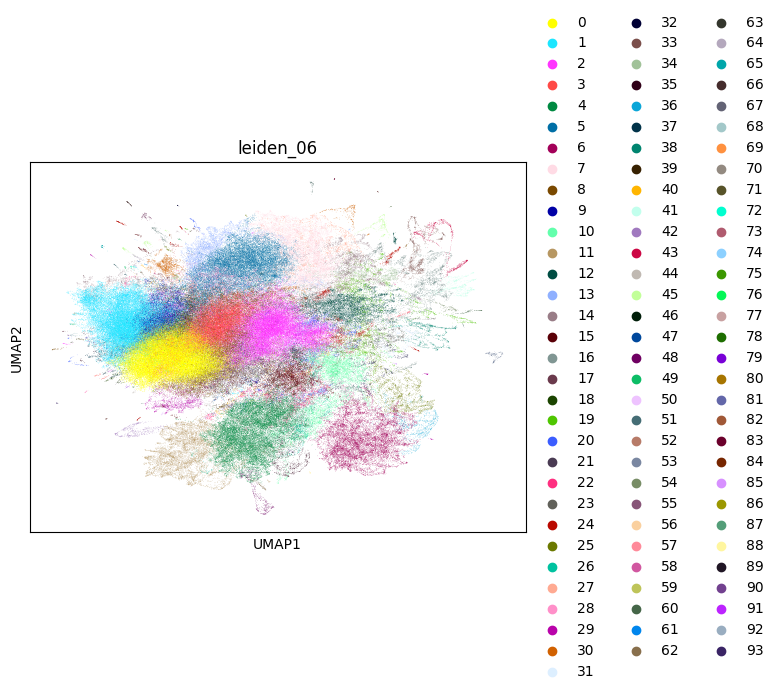

In [316]:
# Step 1: Esegui Leiden clustering e visualizza
sc.tl.leiden(adata_feature, resolution=leiden_resolution, key_added=cluster_col)
#sc.tl.umap(adata_feature)
sc.pl.umap(adata_feature, color=cluster_col)

In [326]:
# Step 2: Filtra i cluster piccoli
cluster_sizes = adata_feature.obs[cluster_col].value_counts()
valid_clusters = cluster_sizes[cluster_sizes >= min_cells].index.tolist()  # oppure solo .index ???
adata_feature_filtered = adata_feature[adata_feature.obs[cluster_col].isin(valid_clusters)].copy()

#print(adata_feature_filtered.obs[cluster_col].value_counts())

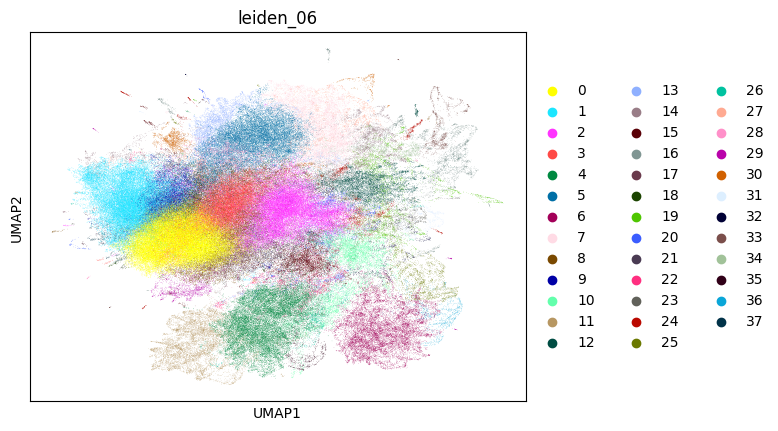

In [385]:
# UMAP sul dataset filtrato
sc.pl.umap(adata_feature_filtered, color=cluster_col)

In [342]:
# Estrai i cluster Leiden e le informazioni sulla cellula
leiden_06 = adata_feature_filtered.obs[cluster_col]

# Crea un DataFrame con cell_id e il risultato del clustering
df_leiden_06 = pd.DataFrame({
    'cell_id': adata_feature_filtered.obs['cell_id'].values,  # Usa .values per ottenere i valori effettivi
    'leiden_06': leiden_06.values  # Assicurati di ottenere i valori dei cluster
})

# Salva il DataFrame in un file CSV
df_leiden_06.to_csv('leiden_06.csv', index=False)

In [364]:
# Step 3: Percentuali globali dinamiche con 38 cluster
cell_types = adata_feature_filtered.obs[cell_type_col].unique()
cell_type_counts = adata_feature_filtered.obs[cell_type_col].value_counts()
total_cells = cell_type_counts.sum()
global_percentages = (cell_type_counts / total_cells) * 100
global_percentages

cell_type_prediction
Malignant    91.820069
Normal        6.840721
Unknown       1.339211
Name: count, dtype: float64

In [380]:
# Step 4: Distribuzione per cluster
cluster_counts = adata_feature_filtered.obs.groupby([cluster_col, cell_type_col]).size().unstack(fill_value=0)
cluster_counts["Total"] = cluster_counts.sum(axis=1)

# Calcolo Fold Change per ciascun tipo cellulare
for ct in cell_types:
    cluster_counts[f"{ct} %"] = cluster_counts.get(ct, 0) / cluster_counts["Total"] * 100

# Calcolo Fold Change dinamico
for ct in cell_types:
    cluster_counts[f"Fold change % {ct}"] = cluster_counts[f"{ct} %"] / global_percentages[ct]

/tmp/ipykernel_148822/4204635942.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts = adata_feature_filtered.obs.groupby([cluster_col, cell_type_col]).size().unstack(fill_value=0)


In [ ]:
# Calcolo percentuali locali
cell_types = cluster_counts.columns.drop("Total")
for ct in cell_types:
    cluster_counts[f"{ct} %"] = cluster_counts[ct] / cluster_counts["Total"] * 100

In [368]:
# Calcolo della crosstab (opzionale se usi già cluster_counts)
crosstab = pd.crosstab(adata_feature_filtered.obs[cluster_col], adata_feature_filtered.obs[cell_type_col])

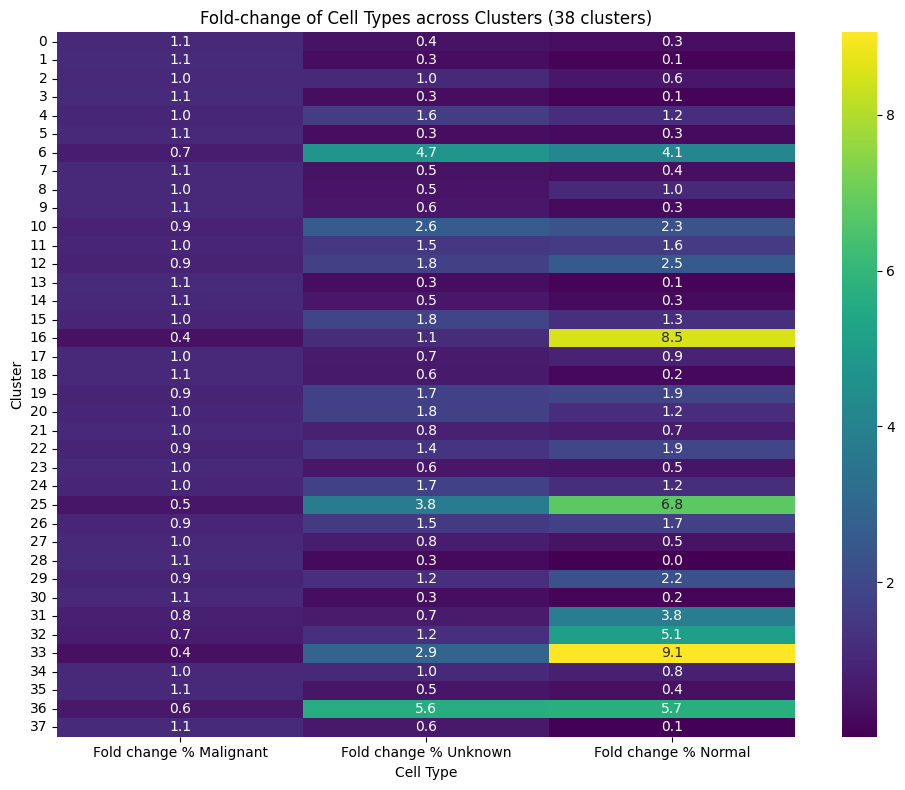

In [382]:
# Visualizzazione dinamica della heatmap
fold_change_cols = [f"Fold change % {ct}" for ct in cell_types]
plt.figure(figsize=(max(10, len(fold_change_cols) * 2), 8))
sns.heatmap(cluster_counts[fold_change_cols], cmap="viridis", annot=True, fmt=".1f")

plt.title(f"Fold-change of Cell Types across Clusters ({len(cluster_counts)} clusters)")
plt.xlabel("Cell Type")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [616]:
# Arricchimento per cluster: quantificare 'malignant', 'normal', 'unknown' per cluster

# === PARAMETRI ===
cluster_col = 'leiden_06'  # <--- Cambia qui per usare altri clustering
label_col = 'cell_type_prediction'  # o 'cell_type'
malignant_label = 'Malignant'  # Valore esatto in adata_feature.obs[label_col]
normal_label = 'Normal'

output_dir = './enrichment_results'
os.makedirs(output_dir, exist_ok=True)

# === CREAZIONE TABELLE ===
# Quanti e che percentuale di cellule Malignant, Normal, e Unknown ci sono in ogni cluster?
enrichment_table = pd.crosstab(adata_feature.obs[cluster_col], adata_feature.obs[label_col])
enrichment_percent = enrichment_table.div(enrichment_table.sum(axis=1), axis=0) * 100

# === ORDINA CLUSTER PER PERCENTUALE DI MALIGNANT ===
if malignant_label in enrichment_percent.columns:
    enrichment_percent = enrichment_percent.sort_values(by=malignant_label, ascending=False)
    enrichment_table = enrichment_table.loc[enrichment_percent.index]
else:
    print(f"⚠️ Warning: '{malignant_label}' non trovato tra le categorie di {label_col}.")

# === SALVATAGGIO CSV ===
cluster_name = cluster_col.replace(' ', '_')
enrichment_table.to_csv(os.path.join(output_dir, f'enrichment_counts_{cluster_name}.csv'))
enrichment_percent.to_csv(os.path.join(output_dir, f'enrichment_percent_{cluster_name}.csv'))

# === PLOT HEATMAP ===
plt.figure(figsize=(10, 6))
sns.heatmap(enrichment_percent, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label': '% cells'})
plt.title(f"Enrichment Heatmap: {cluster_col}", fontsize=14)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.tight_layout()

# === SALVA HEATMAP (.png, .pdf, .svg) ===
for ext in ['png', 'pdf', 'svg']:
    filename = os.path.join(output_dir, f'enrichment_heatmap_{cluster_name}.{ext}')
    plt.savefig(filename, dpi=300)
    print(f"✔️ Heatmap salvata in: {filename}")

plt.close()


✔️ Heatmap salvata in: ./enrichment_results/enrichment_heatmap_leiden_06.png
✔️ Heatmap salvata in: ./enrichment_results/enrichment_heatmap_leiden_06.pdf
✔️ Heatmap salvata in: ./enrichment_results/enrichment_heatmap_leiden_06.svg


In [ ]:
# CREDO CHE QUELLO CHE DOVRESTI FARE è AGGIUNGERE LA CLASSIFICAZIONE D TE CHIAMATA cell_type_prediction E CONFRONTARE COME LE UNKNOWN VENGONO CLASSIFICATE ADESSO

# NON NE SONO SICURA MA CONTROLLA

# LO SCRIPT SOTTO SIA INUTILE POICHè C'è UN'ALTA % DI MALIGNE QUESTO SIGNIFICA CHE TUTTE LE CELLULE VENGONO CLASSIFICATE COME MALIGNANT

# NO BUONO, PER NIENTE BUONO!!!!!

In [622]:
# Classificare le cellule "Unknown" in "Malignant" o "Normal"

# 1.  Verifico in quale cluster si trova l'Unknown.
# 2.  Controllo l’enrichment di "Malignant" e "Normal" in quel cluster.
# 3.  Classifico la cellula come "Malignant" o "Normal" in base all’enrichment.


# === IDENTIFICA LE CELLE 'UNKNOWN' ===
unknown_cells = adata_feature[adata_feature.obs[label_col] == 'Unknown']

# === CLASSSIFICA LE CELLE 'UNKNOWN' PER TUTTI I CLUSTER ===
clustering_columns = ['gmm_clusters_2', 'gmm_clusters_3', 'gmm_clusters_4', 'gmm_clusters_10', 'gmm_clusters_15', 'leiden_06']

# Funzione per classificare le cellule 'unknown' in base al cluster
def classify_unknown_cells(cluster_col):
    # Creiamo la colonna 'predicted_label' per il tipo di clustering specifico
    predicted_label_column = f'predicted_label_{cluster_col}'
    adata_feature.obs[predicted_label_column] = adata_feature.obs.apply(
        lambda x: malignant_label if enrichment_percent.loc[str(x[cluster_col]), malignant_label] > enrichment_percent.loc[str(x[cluster_col]), normal_label]
        else normal_label, axis=1)

# Esegui la classificazione per ciascun tipo di clustering
for cluster_col in clustering_columns:
    classify_unknown_cells(cluster_col)

# === RISULTATO ===
print(adata_feature.obs[['cell_id'] + [f'predicted_label_{cluster_col}' for cluster_col in clustering_columns]].head())

    cell_id predicted_label_gmm_clusters_2 predicted_label_gmm_clusters_3  \
7         8                      Malignant                      Malignant   
9        10                      Malignant                      Malignant   
16       17                      Malignant                      Malignant   
17       18                      Malignant                      Malignant   
18       19                      Malignant                      Malignant   

   predicted_label_gmm_clusters_4 predicted_label_gmm_clusters_10  \
7                       Malignant                       Malignant   
9                       Malignant                       Malignant   
16                      Malignant                       Malignant   
17                      Malignant                       Malignant   
18                      Malignant                       Malignant   

   predicted_label_gmm_clusters_15 predicted_label_leiden_06  
7                        Malignant                 Malignan

/tmp/ipykernel_148822/4285430941.py:33: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.boxplot(data=signature_data, x='classification_group', y=gene_expression_column, hue='classification_group', palette="Set3")


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

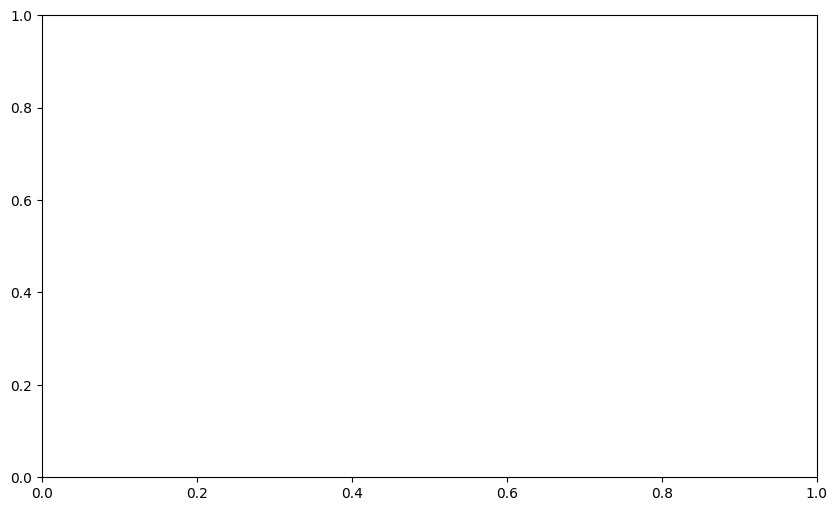

In [630]:
# Seleziono il clustering per la classificazione
cluster_col = 'predicted_label_gmm_clusters_2'

# Creo una nuova colonna che classifica le cellule in base alla label 'Malignant' o 'Normal'
# e 'Unknown -> Malignant' o 'Unknown -> Normal'
def classify_unknown_groups(row, cluster_col):
    if row[cluster_col] == 'Malignant':
        return 'Malignant'
    elif row[cluster_col] == 'Normal':
        return 'Normal'
    else:
        # Verifica se la cella 'Unknown' è stata classificata come maligna o normale
        return 'Unknown -> Malignant' if enrichment_percent.loc[str(row[cluster_col]), 'Malignant'] > enrichment_percent.loc[str(row[cluster_col]), 'Normal'] else 'Unknown -> Normal'

# Aggiungo una colonna per il gruppo di classificazione
adata_feature.obs['classification_group'] = adata_feature.obs.apply(classify_unknown_groups, axis=1, cluster_col=cluster_col)

# Convertiamo la matrice sparsa in un DataFrame di pandas
signature_data = pd.DataFrame.sparse.from_spmatrix(adata_feature.X)

# Etichettiamo le colonne con i nomi dei geni (se disponibili)
signature_data.columns = adata_feature.var_names

# Aggiungiamo la colonna 'classification_group' per associare i gruppi (malignant, normal, ecc.)
signature_data['classification_group'] = adata_feature.obs['classification_group']

# Seleziona un gene per il boxplot, ad esempio il primo gene nella matrice
# Qui utilizziamo il primo gene (indice 0), ma puoi cambiarlo in base alle tue esigenze
gene_expression_column = signature_data.columns[0]  # Primo gene (puoi cambiarlo in base alle tue esigenze)

# Creiamo il boxplot, utilizzando 'hue' per colorare in base ai gruppi
plt.figure(figsize=(10, 6))
sns.boxplot(data=signature_data, x='classification_group', y=gene_expression_column, hue='classification_group', palette="Set3")

# Aggiungiamo un titolo e etichette
plt.title('Boxplot of Malignant and Normal Signatures')
plt.xlabel('Classification Group')
plt.ylabel('Gene Expression Signature')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostra il grafico
plt.show()

In [638]:
def classify_unknown_groups(row, cluster_col):
    if row[cluster_col] == 'Malignant':
        return 'Malignant'
    elif row[cluster_col] == 'Normal':
        return 'Normal'
    else:
        mal = enrichment_percent.loc[str(row[cluster_col]), 'Malignant']
        norm = enrichment_percent.loc[str(row[cluster_col]), 'Normal']
        print(f"Cluster: {row[cluster_col]}, Malignant: {mal}, Normal: {norm}")  # Debug
        
        # Modifica la logica per un confronto meno rigido
        if mal > norm and mal > 60:  # Ad esempio, 60% di "Malignant" è sufficiente
            return 'Unknown -> Malignant'
        elif norm > mal and norm > 60:  # 60% di "Normal" per etichettare come "Normal"
            return 'Unknown -> Normal'
        else:
            return 'Unknown'  # Lascia "Unknown" se la percentuale è più equilibrata

# Applica la funzione per vedere come vengono classificati i gruppi
adata_feature.obs['classification_group'] = adata_feature.obs.apply(classify_unknown_groups, axis=1, cluster_col=cluster_col)

# Verifica nuovamente i risultati
print(adata_feature.obs['classification_group'].value_counts())


classification_group
Malignant    350718
Name: count, dtype: int64
